In [ ]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.1 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=c4f262ef33e6e48e85be1d4e461ab6fad7a3b00f4feddc58c86840891818fc5a
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11335 sha256=c34c3c5b36d681a3b61f01880c696df1e011ac0545d26b96bf4b52a8a05fe031
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
import missingno as msno
from sklearn.impute import SimpleImputer
from keras.optimizers import SGD
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report,confusion_matrix
from fancyimpute import IterativeImputer as MI
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [ ]:
df = pd.read_csv("/content/abc.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95143 entries, 0 to 95142
Data columns (total 18 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Deck hyperlink                                            95143 non-null  object 
 1   Total maindeck cards                                      89671 non-null  float64
 2   Lands (without MDFCs)                                     89671 non-null  float64
 3   Average mana value (counting land/spell MDFCs as spells)  89671 non-null  float64
 4   Nonmythic land/spell MDFCs                                89671 non-null  float64
 5   Mythic land/spell MDFCs                                   89671 non-null  float64
 6   Total land/spell MDFCs                                    89671 non-null  float64
 7   Cheap card draw                                           89671 non-null  float64
 8   Cheap mana prod 

In [ ]:
df.isnull().sum()

Deck hyperlink                                                  0
Total maindeck cards                                         5472
Lands (without MDFCs)                                        5472
Average mana value (counting land/spell MDFCs as spells)     5472
Nonmythic land/spell MDFCs                                   5472
Mythic land/spell MDFCs                                      5472
Total land/spell MDFCs                                       5472
Cheap card draw                                              5472
Cheap mana prod                                              5472
Sum of cheap card draw and cheap mana prod                   5472
Date of event                                                5472
Format                                                       5472
Companion (based on sideboard inclusion)                    86607
Companion present (1 or 0)                                   5472
Wins                                                         5472
Losses    

<ipython-input-6-e74d8c757bd6>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),vmax=0.8,square=True,cmap='GnBu',linecolor='r',annot=True, annot_kws={'size':9})


<Axes: title={'center': 'Corr, Pearson'}>

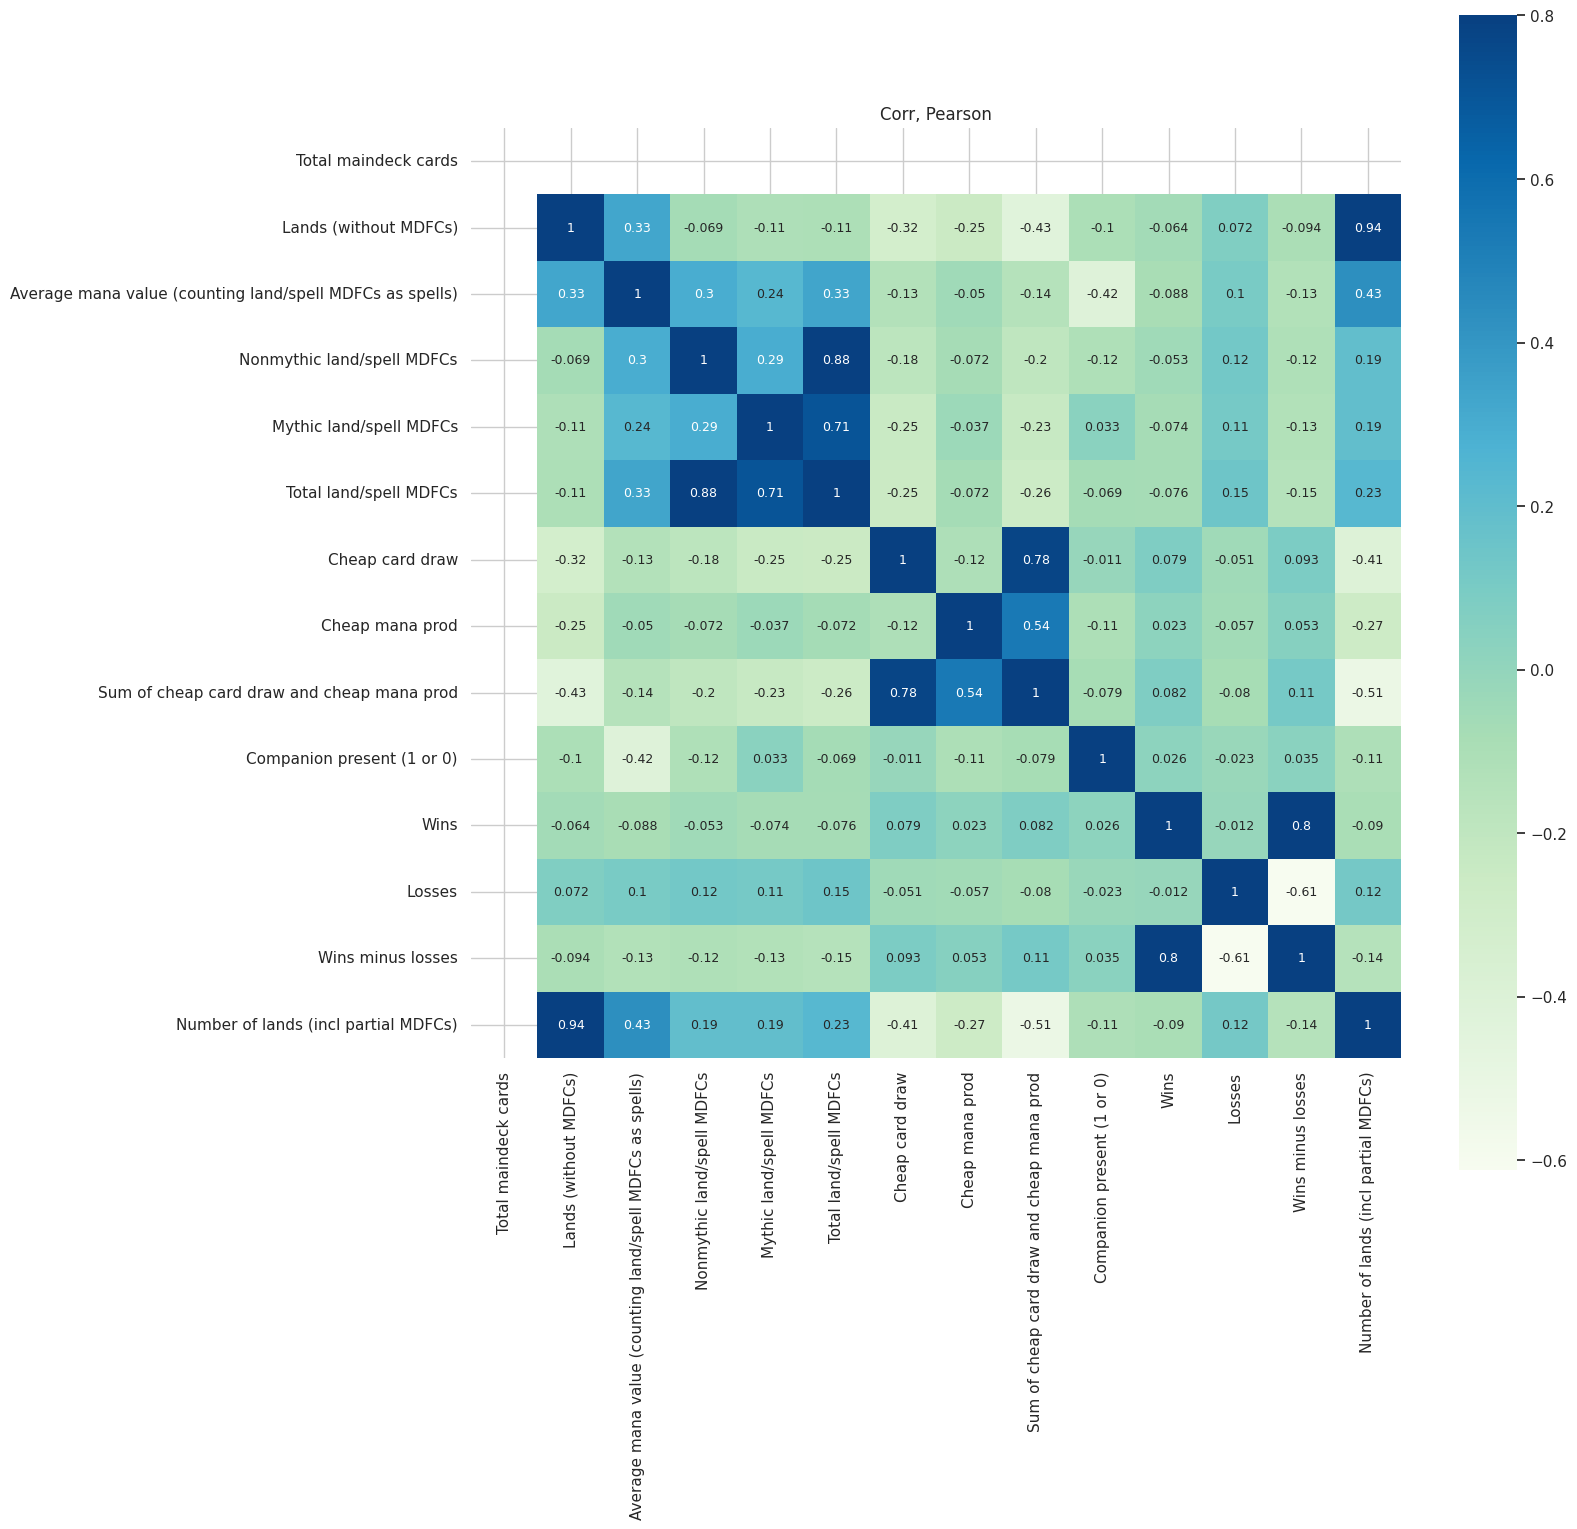

In [ ]:
sns.set(style='whitegrid', font_scale=1)
plt.figure(figsize=(15,15))
plt.title("Corr, Pearson")
sns.heatmap(df.corr(),vmax=0.8,square=True,cmap='GnBu',linecolor='r',annot=True, annot_kws={'size':9})

In [ ]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Total maindeck cards,89671.0,60.000000,0.000000,60.000000,60.000000,60.000000,60.000000,60.000000
Lands (without MDFCs),89671.0,21.991625,3.390165,11.000000,20.000000,22.000000,24.000000,38.000000
Average mana value (counting land/spell MDFCs as spells),89671.0,2.476434,0.687313,0.545455,2.026316,2.452381,2.923077,5.926829
Nonmythic land/spell MDFCs,89671.0,0.724872,1.702599,0.000000,0.000000,0.000000,0.000000,13.000000
Mythic land/spell MDFCs,89671.0,0.475471,1.139788,0.000000,0.000000,0.000000,0.000000,10.000000
Total land/spell MDFCs,89671.0,1.200343,2.311288,0.000000,0.000000,0.000000,1.000000,17.000000
Cheap card draw,89671.0,4.164914,4.665574,0.000000,0.000000,4.000000,7.000000,19.000000
Cheap mana prod,89671.0,1.854267,3.487411,0.000000,0.000000,0.000000,4.000000,24.000000
Sum of cheap card draw and cheap mana prod,89671.0,6.019181,5.494244,0.000000,1.000000,4.000000,9.000000,35.000000
Companion present (1 or 0),89671.0,0.095192,0.293482,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
df = df.drop(['Companion (based on sideboard inclusion)','Lands (without MDFCs)','Wins'],axis=1)

array([[<Axes: title={'center': 'Total maindeck cards'}>,
        <Axes: title={'center': 'Average mana value (counting land/spell MDFCs as spells)'}>,
        <Axes: title={'center': 'Nonmythic land/spell MDFCs'}>],
       [<Axes: title={'center': 'Mythic land/spell MDFCs'}>,
        <Axes: title={'center': 'Total land/spell MDFCs'}>,
        <Axes: title={'center': 'Cheap card draw'}>],
       [<Axes: title={'center': 'Cheap mana prod'}>,
        <Axes: title={'center': 'Sum of cheap card draw and cheap mana prod'}>,
        <Axes: title={'center': 'Companion present (1 or 0)'}>],
       [<Axes: title={'center': 'Losses'}>,
        <Axes: title={'center': 'Wins minus losses'}>,
        <Axes: title={'center': 'Number of lands (incl partial MDFCs)'}>]],
      dtype=object)

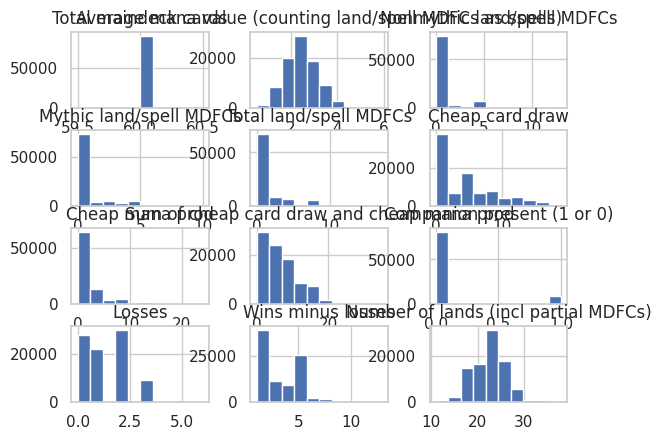

In [ ]:
df.hist()

In [ ]:
df['Date of event'] = pd.to_datetime(df['Date of event'])
df['month'] = df['Date of event'].apply(lambda date:date.month)
df['year'] = df['Date of event'].apply(lambda date:date.year)
df = df.drop('Date of event', axis = 1)

In [ ]:
df = df.drop(['Deck hyperlink'],axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95143 entries, 0 to 95142
Data columns (total 15 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Total maindeck cards                                      89671 non-null  float64
 1   Average mana value (counting land/spell MDFCs as spells)  89671 non-null  float64
 2   Nonmythic land/spell MDFCs                                89671 non-null  float64
 3   Mythic land/spell MDFCs                                   89671 non-null  float64
 4   Total land/spell MDFCs                                    89671 non-null  float64
 5   Cheap card draw                                           89671 non-null  float64
 6   Cheap mana prod                                           89671 non-null  float64
 7   Sum of cheap card draw and cheap mana prod                89671 non-null  float64
 8   Format          

In [ ]:
le = LabelEncoder()
df['Format'] = le.fit_transform(df['Format'])

<Axes: >

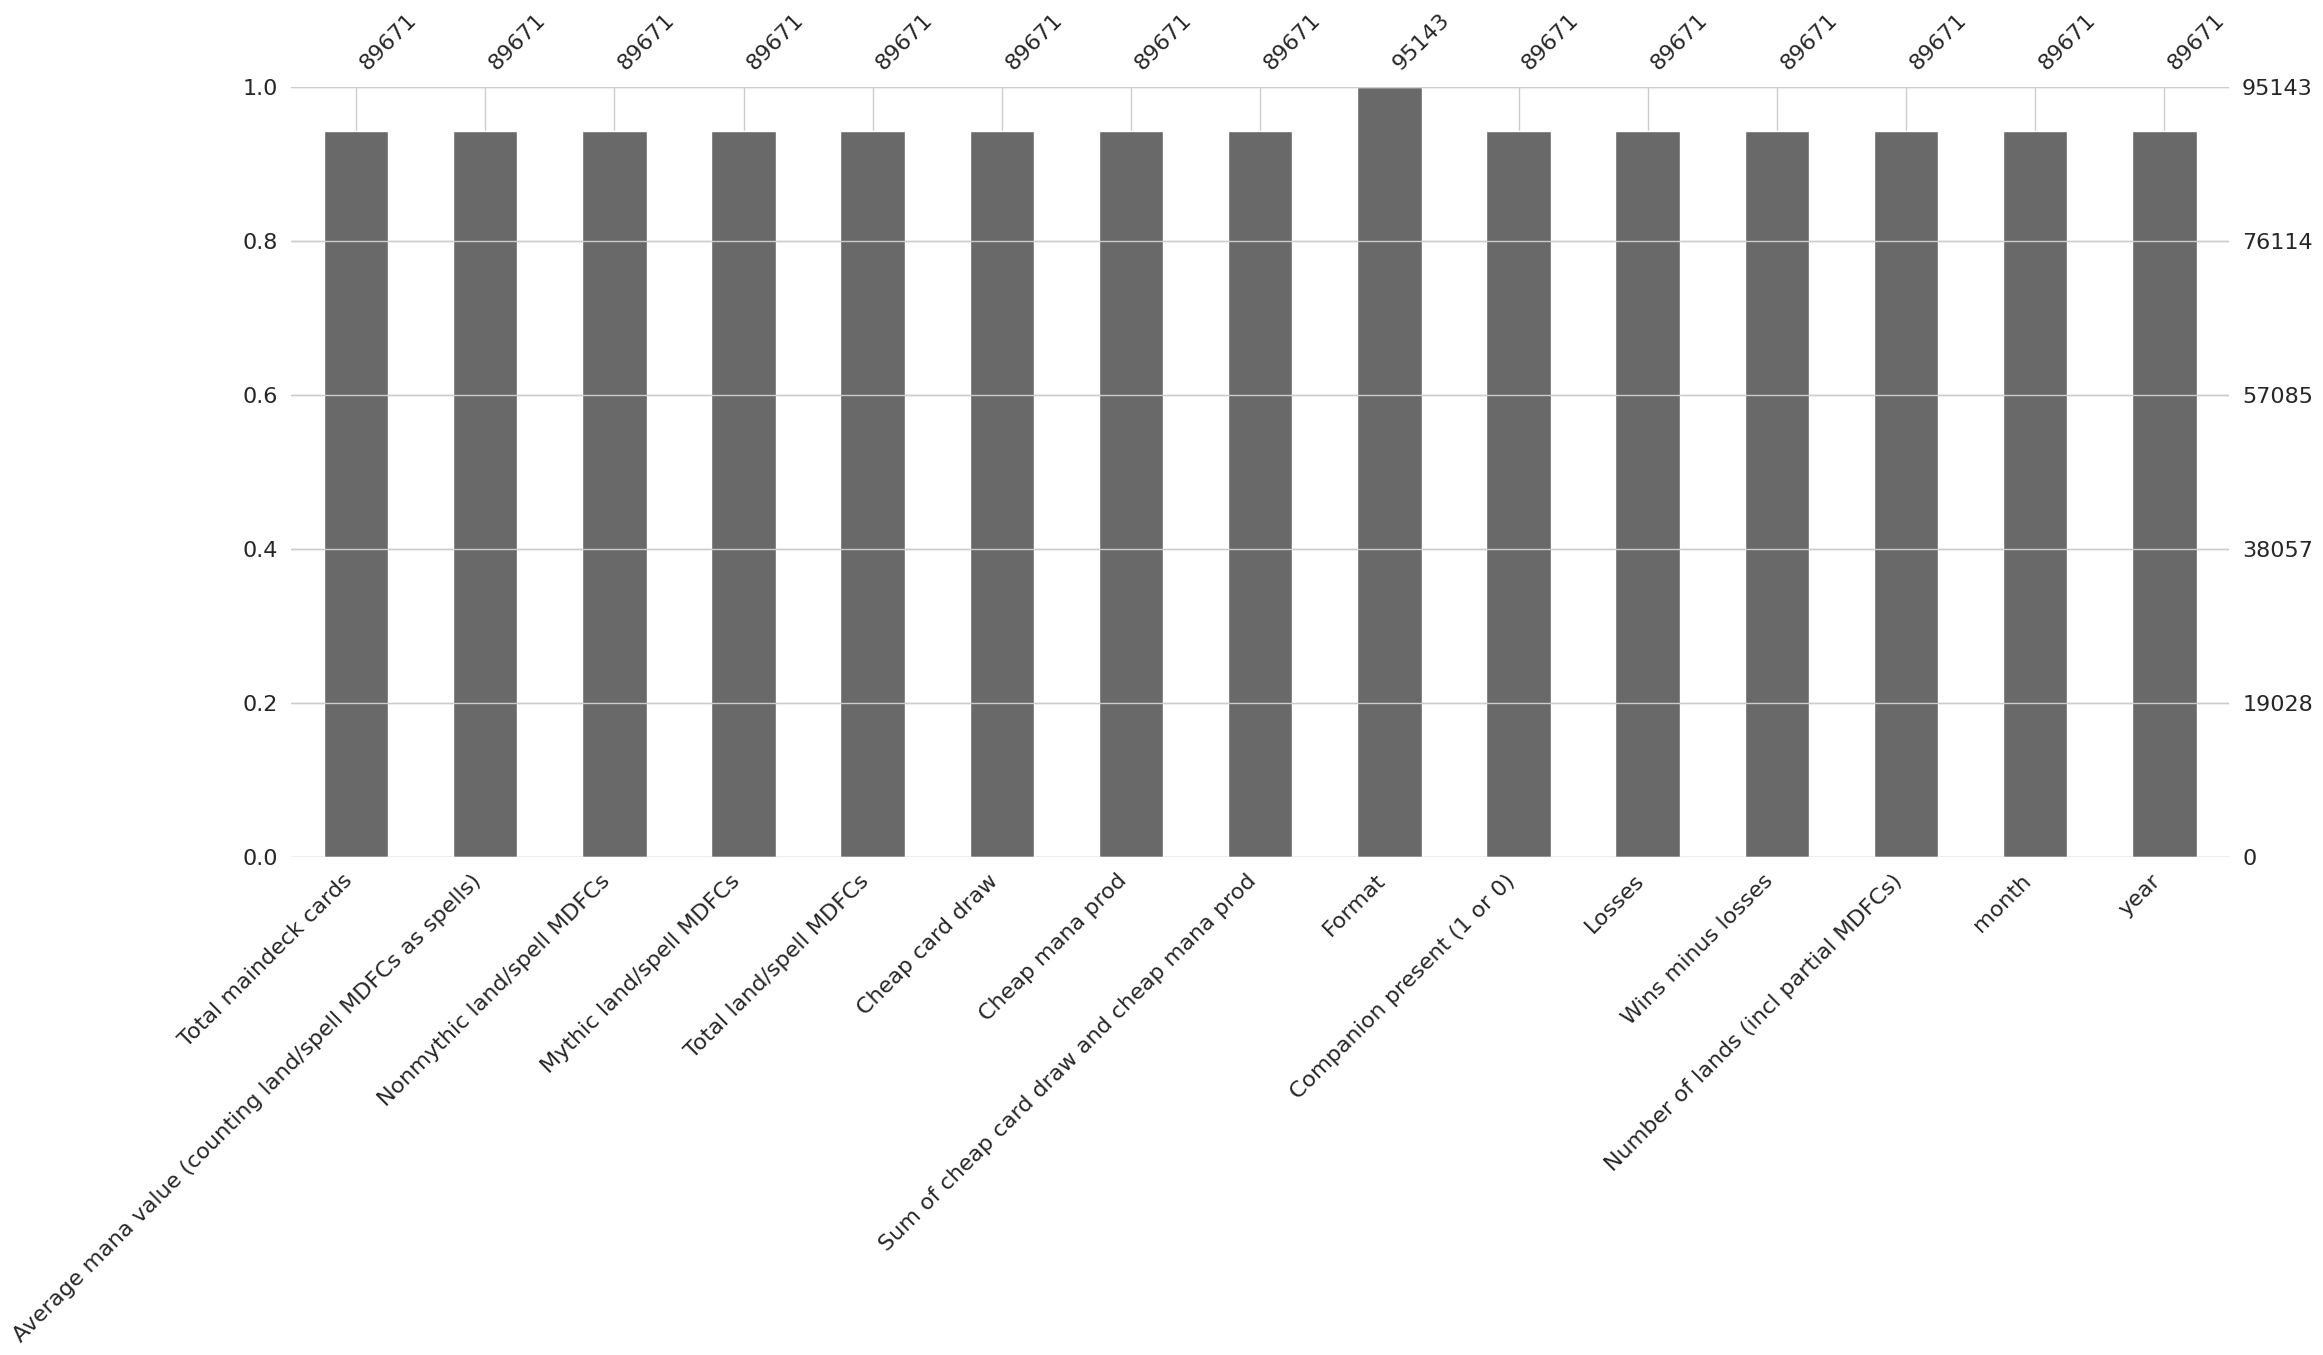

In [ ]:
msno.bar(df)

<Axes: >

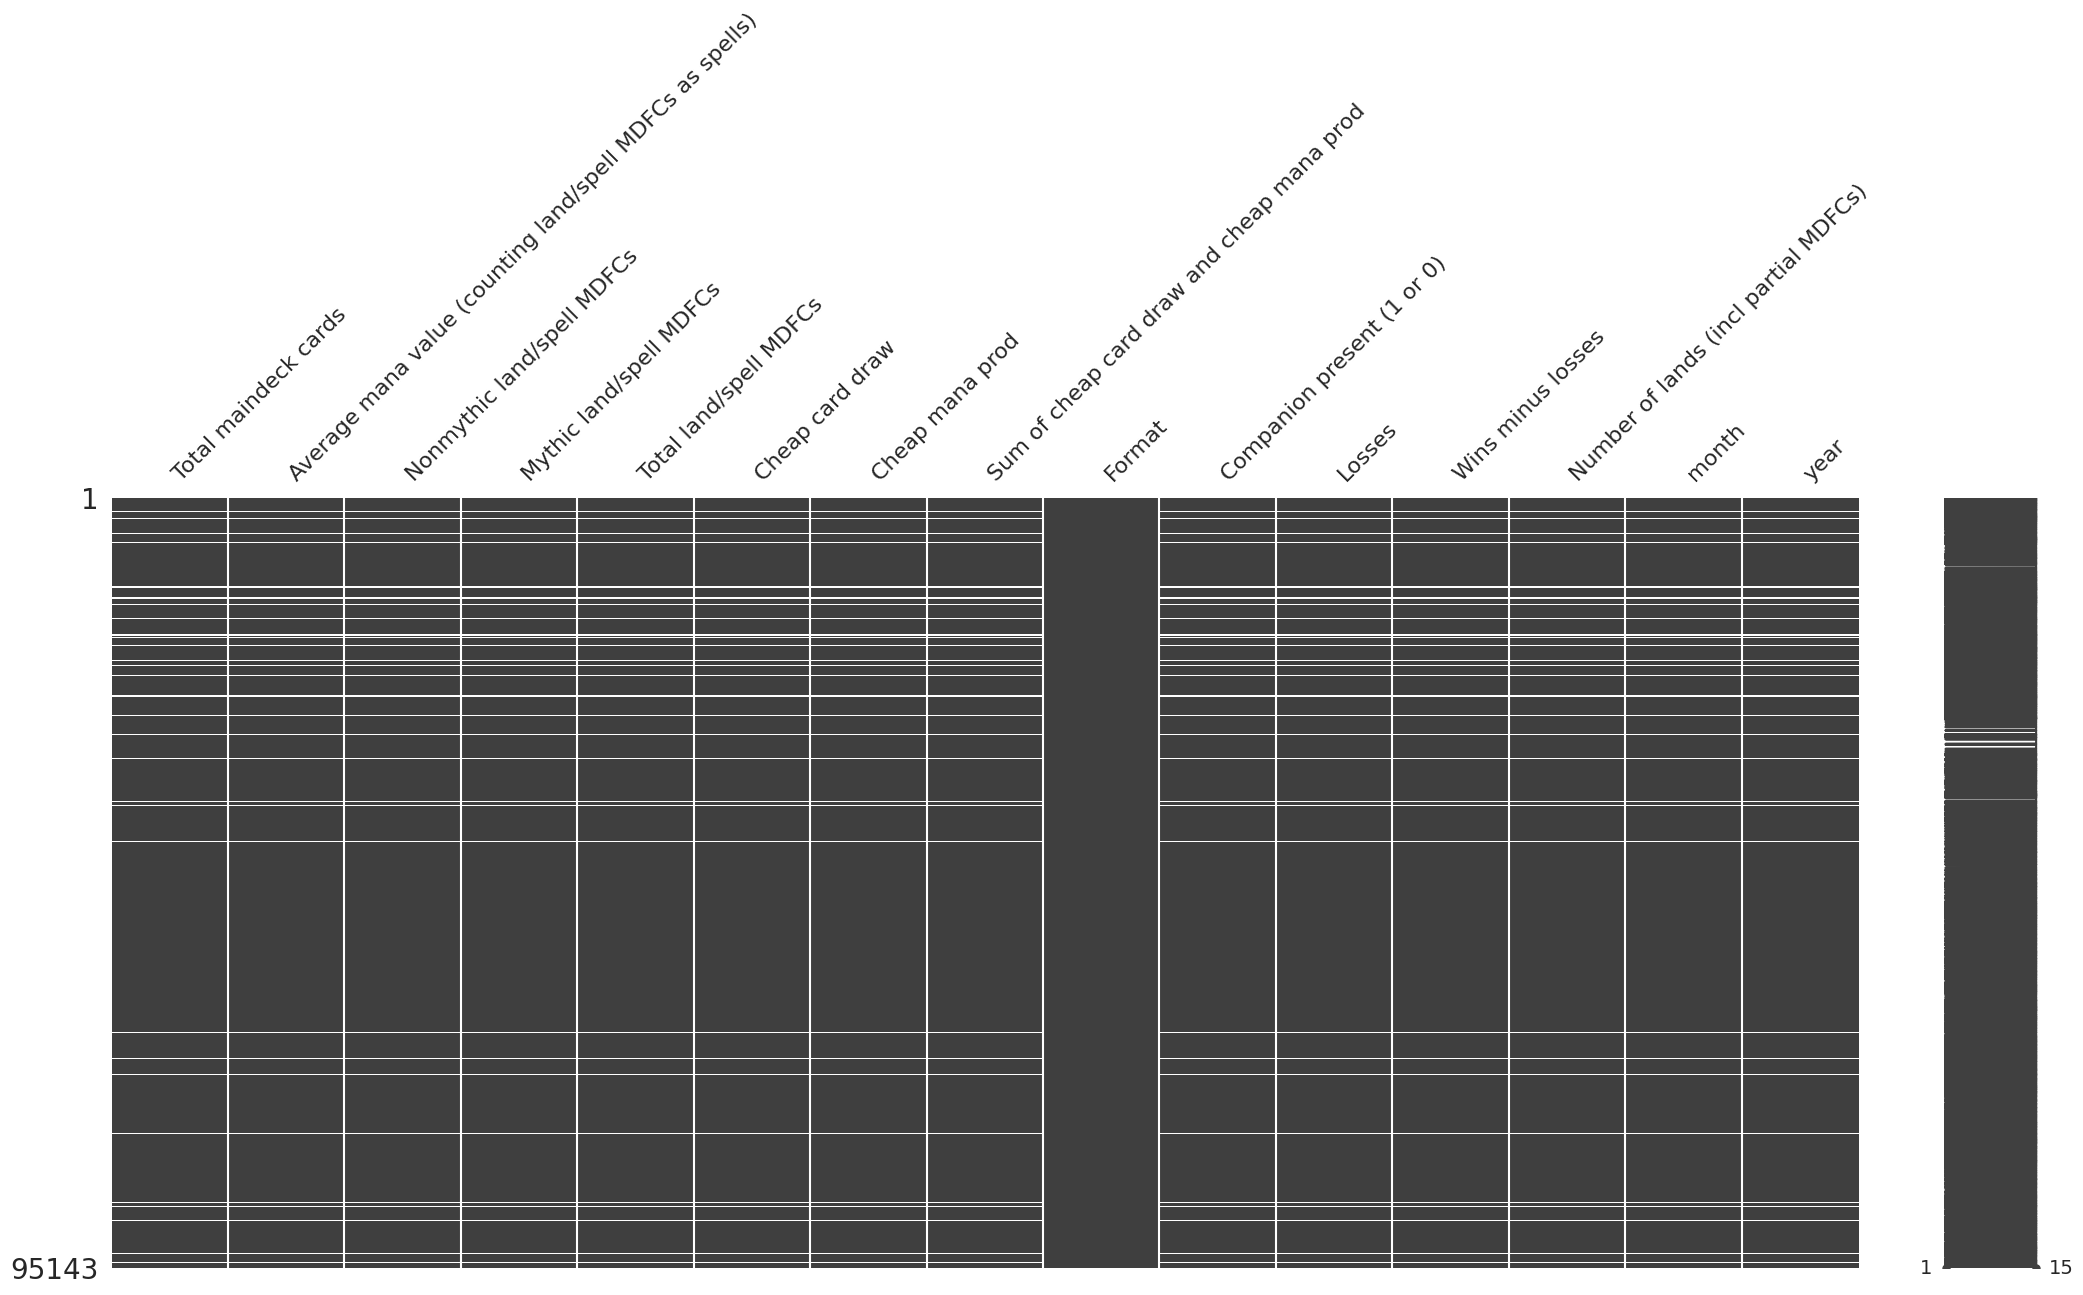

In [ ]:
msno.matrix(df)

In [ ]:
df = df.fillna(df.mean())

<Axes: >

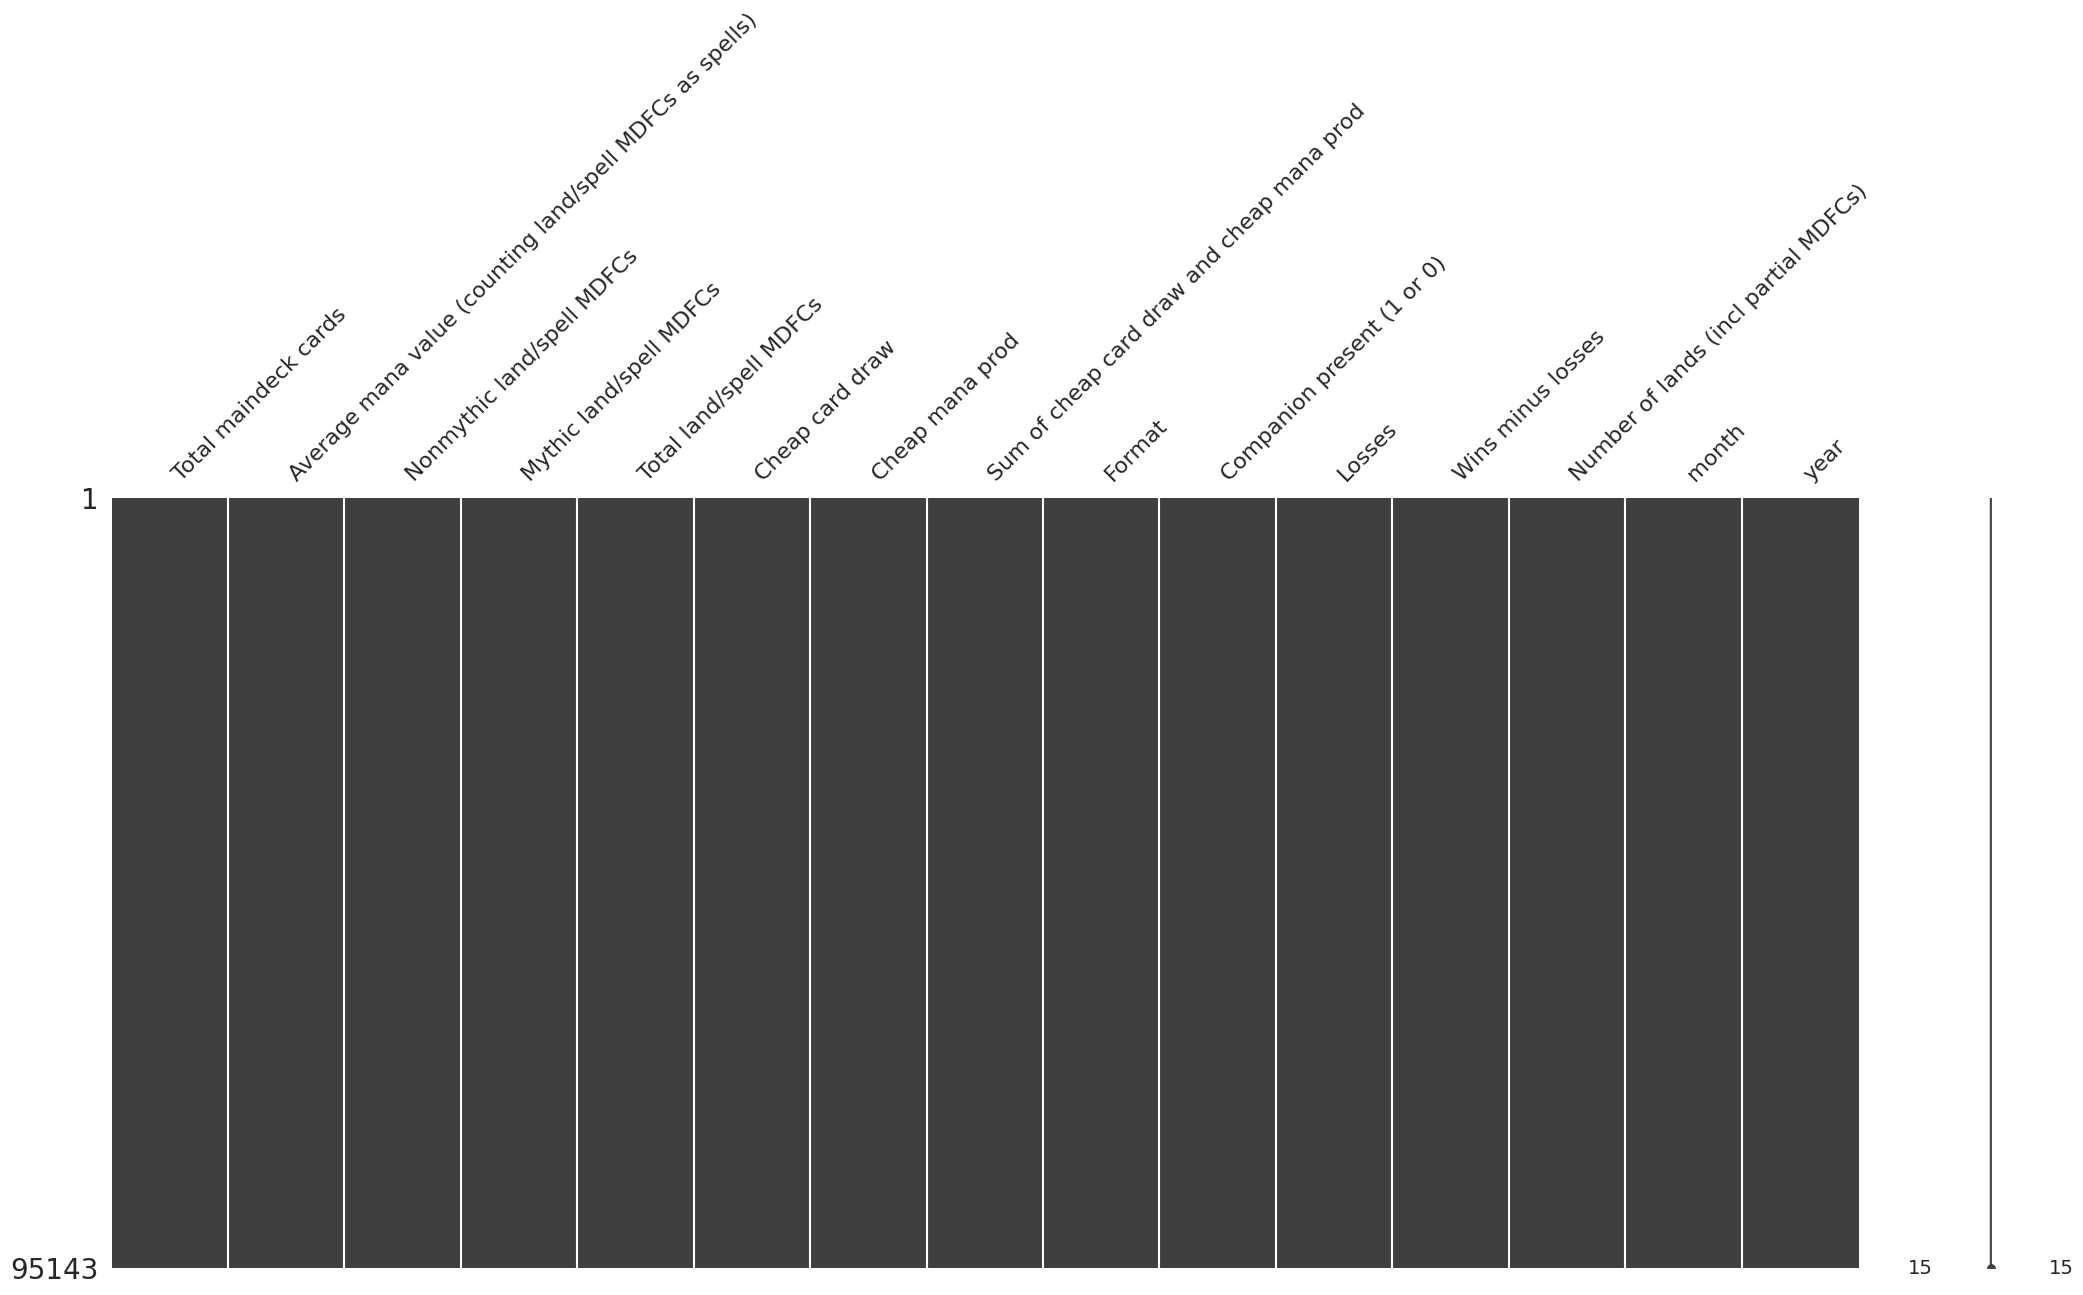

In [ ]:
msno.matrix(df)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Total maindeck cards,95143.0,60.000000,0.000000,60.000000,60.000000,60.000000,60.000000,60.000000
Average mana value (counting land/spell MDFCs as spells),95143.0,2.476434,0.667256,0.545455,2.054054,2.476434,2.888889,5.926829
Nonmythic land/spell MDFCs,95143.0,0.724872,1.652912,0.000000,0.000000,0.000000,0.000000,13.000000
Mythic land/spell MDFCs,95143.0,0.475471,1.106526,0.000000,0.000000,0.000000,0.000000,10.000000
Total land/spell MDFCs,95143.0,1.200343,2.243838,0.000000,0.000000,0.000000,1.200343,17.000000
Cheap card draw,95143.0,4.164914,4.529420,0.000000,0.000000,4.000000,7.000000,19.000000
Cheap mana prod,95143.0,1.854267,3.385638,0.000000,0.000000,0.000000,3.000000,24.000000
Sum of cheap card draw and cheap mana prod,95143.0,6.019181,5.333906,0.000000,2.000000,5.000000,8.000000,35.000000
Format,95143.0,8.652702,4.290853,0.000000,6.000000,9.000000,11.000000,19.000000
Companion present (1 or 0),95143.0,0.095192,0.284918,0.000000,0.000000,0.000000,0.000000,1.000000


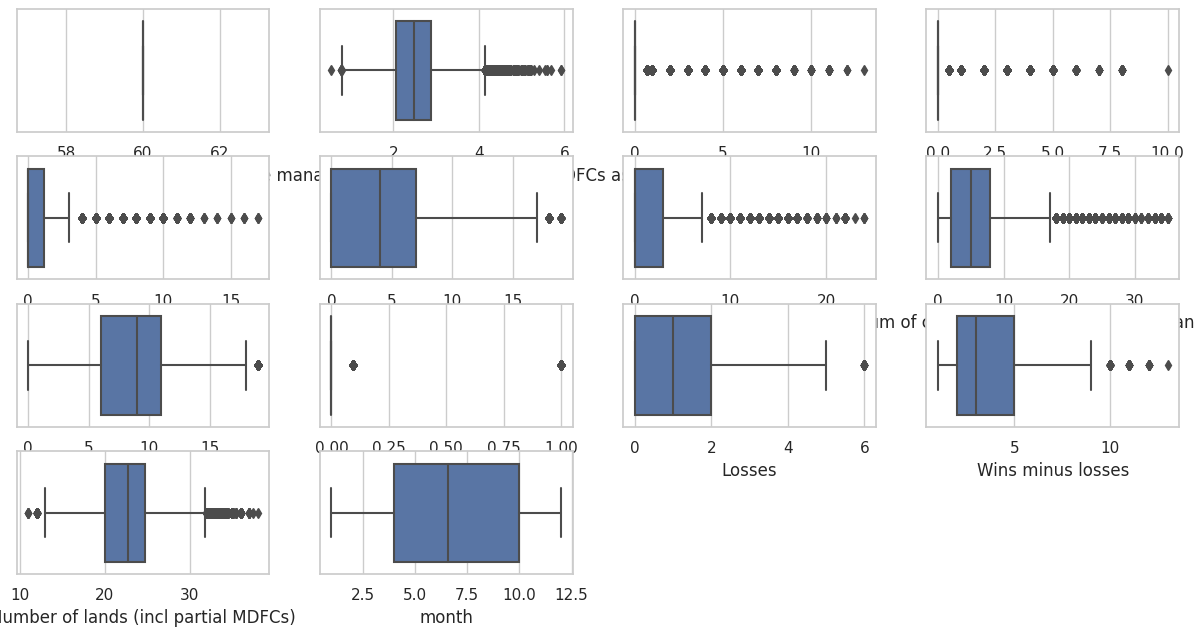

In [ ]:
plt.figure(figsize=(15,15))
col = df.columns[:-1]
for i in enumerate(col):
  plt.subplot(8,4,i[0]+1)
  sns.boxplot(x=i[1],data = df)

In [ ]:
for i in col:
  q1 = df[i].quantile(0.04)
  q4 = df[i].quantile(0.96)
  df[i][df[i]<=q1] = q1
  df[i][df[i]>=q4] = q4

<ipython-input-20-a5bffe38873b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i]<=q1] = q1
<ipython-input-20-a5bffe38873b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i]>=q4] = q4
<ipython-input-20-a5bffe38873b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df[i]<=q1] = q1
<ipython-input-20-a5bffe38873b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

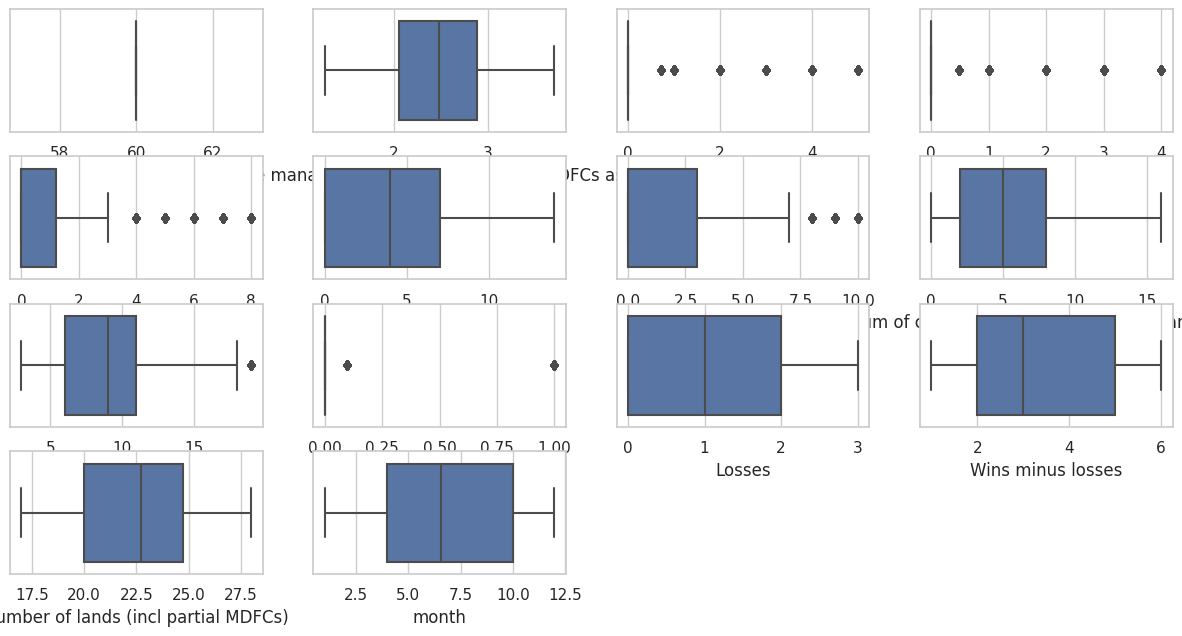

In [ ]:
plt.figure(figsize=(15,15))
col = df.columns[:-1]
for i in enumerate(col):
  plt.subplot(8,4,i[0]+1)
  sns.boxplot(x=i[1],data = df)

In [ ]:
X = df.drop('Number of lands (incl partial MDFCs)', axis=1)
y = df['Number of lands (incl partial MDFCs)']

In [ ]:
scalerMinMax = MinMaxScaler()
scalerMinMax.fit(X)
X = scalerMinMax.transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=60,  test_size=0.3)

In [ ]:
modelANN = Sequential()
modelANN.add(Dense(20,activation='relu'))
modelANN.add(Dense(10,activation='relu'))
modelANN.add(Dense(5,activation='relu'))
modelANN.add(Dense(1))
modelANN.compile(optimizer='adam', loss='mse')

In [ ]:
modelANN.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=100,epochs=70,verbose=1)

Epoch 1/70
666/666 [==============================] - 4s 3ms/step - loss: 504.3779 - val_loss: 490.8489
Epoch 2/70
666/666 [==============================] - 3s 4ms/step - loss: 475.2971 - val_loss: 462.5720
Epoch 3/70
666/666 [==============================] - 2s 2ms/step - loss: 447.6197 - val_loss: 435.3989
Epoch 4/70
666/666 [==============================] - 2s 3ms/step - loss: 421.0088 - val_loss: 409.2565
Epoch 5/70
666/666 [==============================] - 2s 3ms/step - loss: 395.3900 - val_loss: 384.0749
Epoch 6/70
666/666 [==============================] - 2s 3ms/step - loss: 370.7135 - val_loss: 359.8161
Epoch 7/70
666/666 [==============================] - 2s 2ms/step - loss: 346.9357 - val_loss: 336.4388
Epoch 8/70
666/666 [==============================] - 2s 3ms/step - loss: 324.0370 - val_loss: 313.9356
Epoch 9/70
666/666 [==============================] - 2s 3ms/step - loss: 302.0012 - val_loss: 292.2879
Epoch 10/70
666/666 [==============================] - 2s 2ms/st

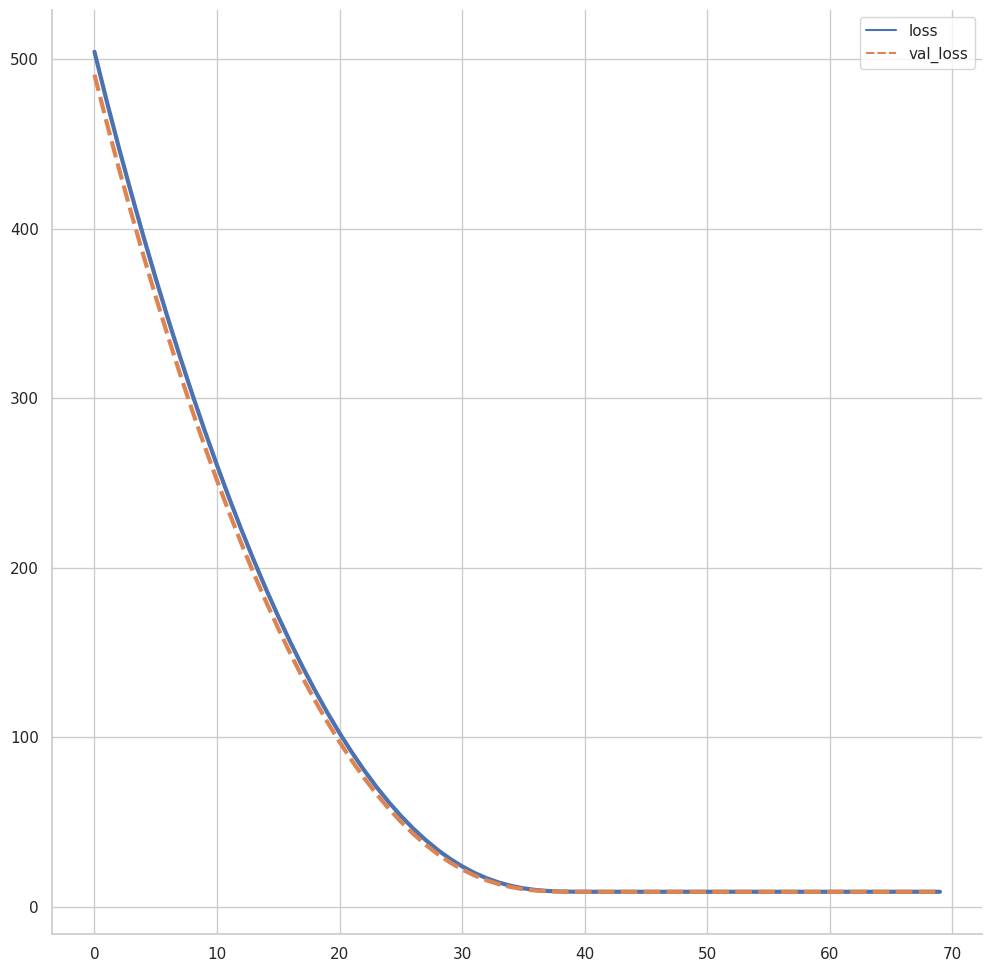

In [ ]:
loss = pd.DataFrame(modelANN.history.history)
plt.figure(figsize=(12,12))
sns.lineplot(data = loss,lw=3)
sns.despine()

In [ ]:
y_pred_Test = modelANN.predict(X_test)
error_absolute = mean_absolute_error(y_test,y_pred_Test)
print(error_absolute)

892/892 [==============================] - 1s 1ms/step
2.4324642433012076


In [ ]:
y_pred_train = modelANN.predict(X_train)
error_absolute_train = mean_absolute_error(y_train,y_pred_train)
print(error_absolute_train)

2082/2082 [==============================] - 3s 1ms/step
2.4405720224539786


In [ ]:
error = []
for i in range(1,5):
  knn = KNeighborsRegressor(n_neighbors=i)
  knn.fit(X_train,y_train)
  p = knn.predict(X_test)
  error.append(np.mean(p!=y_test))

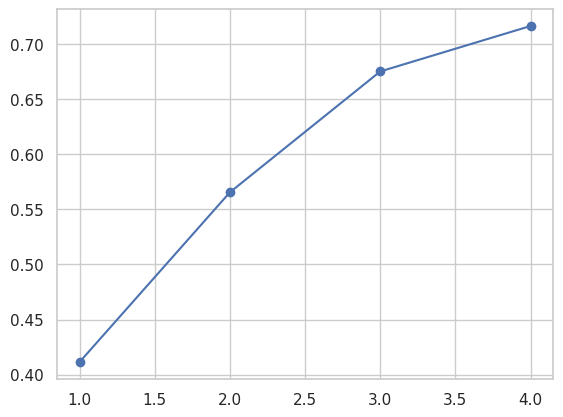

In [ ]:
plt.plot(range(1,5),error,marker="o")

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=3,metric="euclidean")
knn_model.fit(X_train,y_train)
y_predict_knn_train = knn_model.predict(X_train)
y_predict_knn_test = knn_model.predict(X_test)
print(mean_absolute_error(y_train,y_predict_knn_train))
print(mean_absolute_error(y_test,y_predict_knn_test))

0.5631786530530531
0.8790303126277313


In [ ]:
model_svr = SVR(kernel="linear",max_iter=200).fit(X_train,y_train) #linear RBF sigmoid poly
print(model_svr.score(X_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.14147519401657294


In [ ]:
print(model_svr.score(X_train,y_train))

0.14572885606496266


CATEGORICAAAAAAAAL

In [ ]:
df['Format'] = df['Format'].replace([5, 7, 10, 12, 13, 15,18], 17)

In [ ]:
X = df.drop('Format', axis=1)
y = df['Format']

In [ ]:
y.value_counts()

11    27621
6     21822
4     10649
9      9743
3      8915
19     5472
8      5213
16     2235
17     2170
14     1303
Name: Format, dtype: int64

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X,y)

In [ ]:
scalerMinMax = MinMaxScaler()
scalerMinMax.fit(X_rus)
X_rus_es = scalerMinMax.transform(X_rus)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rus_es,y_rus,random_state=60,  test_size=0.3)

KNN

In [ ]:
error = []
for i in range(1,8):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train,y_train)
  p = knn.predict(X_test)
  error.append(np.mean(p!=y_test))

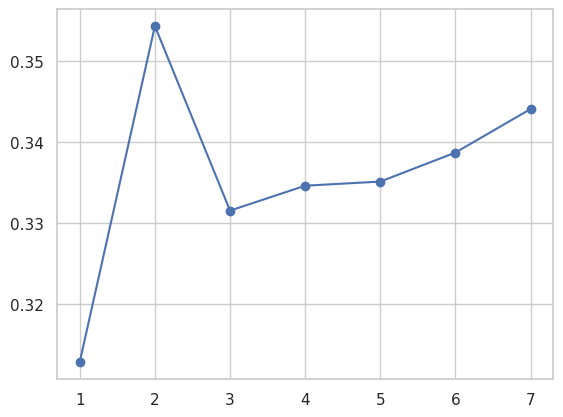

In [ ]:
plt.plot(range(1,8),error,marker="o")

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=4,metric="euclidean")
knn_model.fit(X_train,y_train)
y_predict_knn_train = knn_model.predict(X_train)
y_predict_knn_test = knn_model.predict(X_test)
print(mean_absolute_error(y_train,y_predict_knn_train))
print(mean_absolute_error(y_test,y_predict_knn_test))

In [ ]:
y_predict_knn_test = knn_model.predict(X_test)

In [ ]:
y_predict_knn_train = knn_model.predict(X_train)

In [ ]:
print(classification_report(y_test,y_predict_knn_test))

              precision    recall  f1-score   support

           3       0.59      0.65      0.62       394
           4       0.61      0.59      0.60       437
           6       0.50      0.43      0.46       380
           8       0.74      0.78      0.76       333
           9       0.58      0.49      0.53       405
          11       0.74      0.68      0.71       408
          14       0.61      0.69      0.65       386
          16       0.70      0.84      0.77       369
          17       0.55      0.51      0.53       380
          19       1.00      1.00      1.00       417

    accuracy                           0.67      3909
   macro avg       0.66      0.67      0.66      3909
weighted avg       0.66      0.67      0.66      3909



In [ ]:
print(confusion_matrix(y_test,y_predict_knn_test))

[[256  18  22  12  24  40   2   1  19   0]
 [ 25 256  29  28   6   5  54  22  12   0]
 [ 37  35 165  21  23   8  35  25  31   0]
 [  4  36  10 259   2   1   2  19   0   0]
 [ 39   9  37  16 200  20  17  10  57   0]
 [ 66   5   9   2  23 278   2   1  22   0]
 [  0  42  17   2   8   0 267  38  12   0]
 [  0   7   8   6   4   0  29 311   4   0]
 [  9  12  34   2  57  25  32  17 192   0]
 [  0   0   0   0   0   0   0   0   0 417]]


In [ ]:
print(classification_report(y_train,y_predict_knn_train))

              precision    recall  f1-score   support

           3       0.70      0.81      0.75       909
           4       0.70      0.72      0.71       866
           6       0.75      0.64      0.69       923
           8       0.86      0.85      0.86       970
           9       0.76      0.68      0.72       898
          11       0.86      0.80      0.83       895
          14       0.74      0.82      0.78       917
          16       0.81      0.88      0.85       934
          17       0.74      0.70      0.72       923
          19       1.00      1.00      1.00       886

    accuracy                           0.79      9121
   macro avg       0.79      0.79      0.79      9121
weighted avg       0.79      0.79      0.79      9121



In [ ]:
print(confusion_matrix(y_train,y_predict_knn_train))

[[738  14  20  22  32  55   8   1  19   0]
 [ 45 622  22  37   7   4  86  32  11   0]
 [ 77  60 589  19  28   8  43  44  55   0]
 [ 11  63  21 826   2   1   3  42   1   0]
 [ 78  19  40  35 610  17  16   9  74   0]
 [ 75   6  18   6  33 713   2   1  41   0]
 [  2  67  30   2   7   1 754  35  19   0]
 [  1  18   7   6   2   1  69 824   6   0]
 [ 23  24  41   5  83  30  43  26 647   1]
 [  0   0   0   0   0   0   0   0   0 886]]


SVC

In [ ]:
model_svc = SVC(kernel="poly",max_iter=500).fit(X_train,y_train) #linear RBF sigmoid poly
print(model_svc.score(X_test,y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.5876183167050396


In [ ]:
print(model_svc.score(X_train,y_train))

0.6301940576691152


In [ ]:
y_predict_svm_train = model_svc.predict(X_train)

In [ ]:
print(classification_report(y_train,y_predict_svm_train))

              precision    recall  f1-score   support

           3       0.55      0.38      0.45       909
           4       0.64      0.39      0.49       866
           6       0.58      0.19      0.29       923
           8       0.66      0.88      0.75       970
           9       0.47      0.44      0.45       898
          11       0.59      0.75      0.66       895
          14       0.63      0.65      0.64       917
          16       0.59      0.93      0.72       934
          17       0.56      0.67      0.61       923
          19       1.00      1.00      1.00       886

    accuracy                           0.63      9121
   macro avg       0.63      0.63      0.61      9121
weighted avg       0.63      0.63      0.61      9121



In [ ]:
print(confusion_matrix(y_train,y_predict_svm_train))

[[349  51  35  46 181 209   6   4  28   0]
 [ 17 340   9 227  22  10 112  98  31   0]
 [ 33  52 174 110 120  74  94 105 161   0]
 [  1  39   3 850   5   5   3  63   1   0]
 [126  18  27  37 392 108  33  20 137   0]
 [ 95  10   3   7  50 673   2   1  54   0]
 [  0   2   8   0   4   0 597 249  57   0]
 [  0   2   1   0   2   0  51 866  12   0]
 [ 13  15  38  19  57  57  46  55 621   2]
 [  0   0   0   0   0   0   0   0   0 886]]


In [ ]:
y_predict_svm_test = knn_model.predict(X_test)

In [ ]:
print(classification_report(y_test,y_predict_svm_test))

              precision    recall  f1-score   support

           3       0.59      0.65      0.62       394
           4       0.61      0.59      0.60       437
           6       0.50      0.43      0.46       380
           8       0.74      0.78      0.76       333
           9       0.58      0.49      0.53       405
          11       0.74      0.68      0.71       408
          14       0.61      0.69      0.65       386
          16       0.70      0.84      0.77       369
          17       0.55      0.51      0.53       380
          19       1.00      1.00      1.00       417

    accuracy                           0.67      3909
   macro avg       0.66      0.67      0.66      3909
weighted avg       0.66      0.67      0.66      3909



In [ ]:
print(confusion_matrix(y_test,y_predict_svm_test))

[[256  18  22  12  24  40   2   1  19   0]
 [ 25 256  29  28   6   5  54  22  12   0]
 [ 37  35 165  21  23   8  35  25  31   0]
 [  4  36  10 259   2   1   2  19   0   0]
 [ 39   9  37  16 200  20  17  10  57   0]
 [ 66   5   9   2  23 278   2   1  22   0]
 [  0  42  17   2   8   0 267  38  12   0]
 [  0   7   8   6   4   0  29 311   4   0]
 [  9  12  34   2  57  25  32  17 192   0]
 [  0   0   0   0   0   0   0   0   0 417]]


CNNA

In [ ]:
y_rus = pd.get_dummies(y_rus)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rus_es,y_rus,random_state=60,  test_size=0.3)

In [ ]:
modelrus = Sequential()
modelrus.add(Dense(32, activation='relu'))
modelrus.add(Dense(15, activation='relu'))
modelrus.add(Dense(10, activation='softmax'))

modelrus.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
modelrus.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=60, epochs=150, verbose=1)


Epoch 1/150
153/153 [==============================] - 1s 4ms/step - loss: 2.2030 - accuracy: 0.2095 - val_loss: 2.0071 - val_accuracy: 0.2886
Epoch 2/150
153/153 [==============================] - 1s 3ms/step - loss: 1.8069 - accuracy: 0.3678 - val_loss: 1.6450 - val_accuracy: 0.4751
Epoch 3/150
153/153 [==============================] - 0s 3ms/step - loss: 1.5508 - accuracy: 0.4785 - val_loss: 1.4893 - val_accuracy: 0.4648
Epoch 4/150
153/153 [==============================] - 0s 3ms/step - loss: 1.4371 - accuracy: 0.4873 - val_loss: 1.4022 - val_accuracy: 0.4925
Epoch 5/150
153/153 [==============================] - 0s 3ms/step - loss: 1.3643 - accuracy: 0.5124 - val_loss: 1.3553 - val_accuracy: 0.5055
Epoch 6/150
153/153 [==============================] - 0s 3ms/step - loss: 1.3181 - accuracy: 0.5280 - val_loss: 1.3072 - val_accuracy: 0.5193
Epoch 7/150
153/153 [==============================] - 0s 3ms/step - loss: 1.2805 - accuracy: 0.5436 - val_loss: 1.2803 - val_accuracy: 0.5283

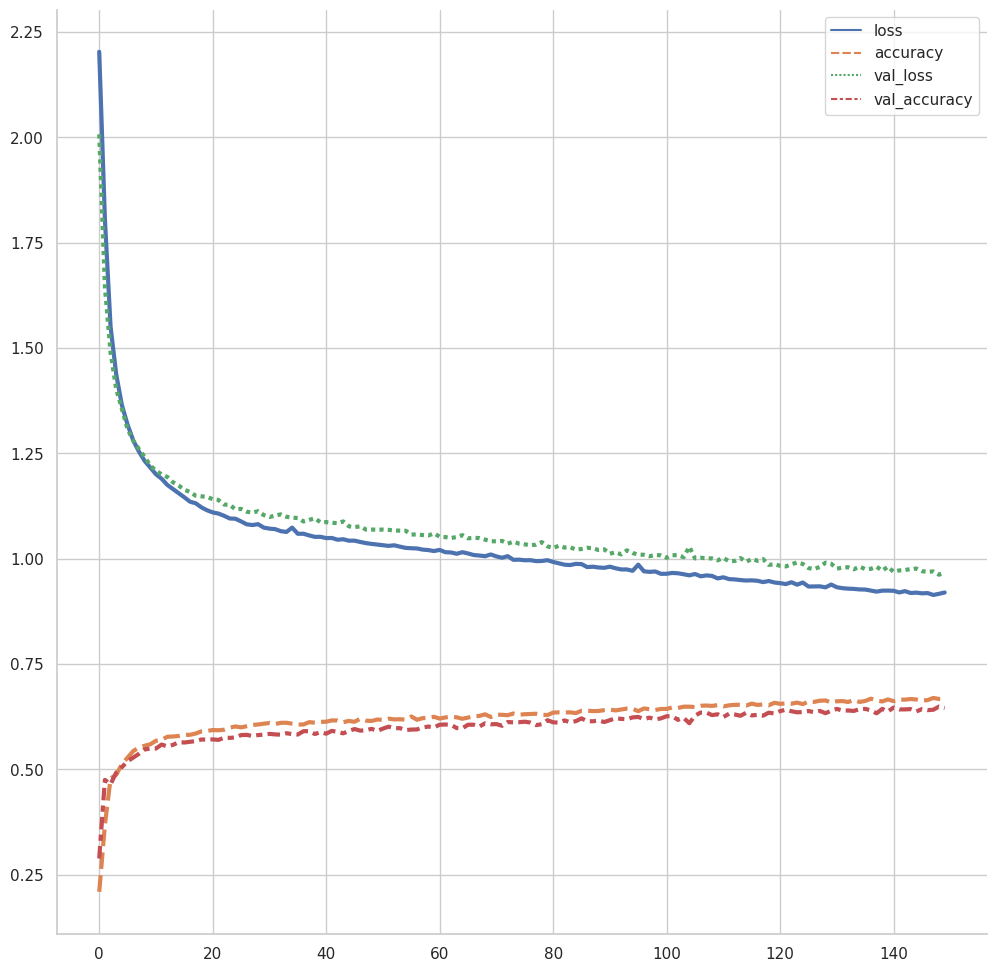

In [ ]:
loss = pd.DataFrame(modelrus.history.history)
plt.figure(figsize=(12,12))
sns.lineplot(data = loss,lw=3)
sns.despine()

In [ ]:
from sklearn.metrics import classification_report
y_predict=modelrus.predict(X_test)
y_predict= (y_predict>0.5)
print(classification_report(y_test,y_predict))

123/123 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.60      0.45      0.52       394
           1       0.73      0.35      0.48       437
           2       0.67      0.14      0.23       380
           3       0.71      0.73      0.72       333
           4       0.70      0.28      0.40       405
           5       0.85      0.53      0.66       408
           6       0.68      0.59      0.63       386
           7       0.74      0.77      0.76       369
           8       0.56      0.45      0.50       380
           9       1.00      1.00      1.00       417

   micro avg       0.74      0.53      0.61      3909
   macro avg       0.72      0.53      0.59      3909
weighted avg       0.73      0.53      0.59      3909
 samples avg       0.53      0.53      0.53      3909



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
